In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torchtext
from torchtext.data import Iterator, BucketIterator
from torchvision import transforms, utils
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score as f1
import pandas as pd

In [2]:
class Lstm(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 dropout
                 ):
        super(Lstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.relu = nn.LeakyReLU()
        self.layer = nn.Linear(self.hidden_size*2, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 

        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = inpt[-1,:,:].view(batch_size,1, self.hidden_size * 2)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

In [3]:
class CNN(nn.Module): 
    def __init__(self,  #num channels
                 input_size,
                 num_channels,
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(CNN, self).__init__()
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.num_channels = num_channels
        self.dropout = dropout
        self.max_features = 72
        
        self.emb = nn.Embedding(len(TEXT.vocab),input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        self.emb_dropout = nn.Dropout2d(dropout)
        
        self.conv = nn.Conv1d(self.max_features, 
                              self.num_channels,
                              self.kernel_size)
        
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        
        self.output_size = (input_size - int(self.kernel_size/2)*2)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels)
        self.layer = nn.Linear(self.output_size,1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt):
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt = inpt.permute(1,0,2)
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

In [4]:
class lstm_cnn(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 num_channels, #num channels
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(lstm_cnn, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        
        self.conv = nn.Conv1d(1, 
                              num_channels,
                              kernel_size)
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        # 2 for bi direction
        self.output_size = 2*(self.hidden_size - self.kernel_size)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels+2)
        self.layer = nn.Linear(self.output_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        
        #formating output from lstm to be of id conv size
        inpt = inpt[-1,:,:].view(batch_size,1, self.hidden_size * 2)
        
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

In [5]:
class Attention(nn.Module):
    def __init__(self, batch_size, size):
        super(Attention, self).__init__()
        self.word_weight = nn.Linear(size, size)
        self.tanh = nn.Tanh()
        self.context_weight = nn.Linear(size, 1, bias = False)
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, inpt):
        inpt = inpt.permute(1,0,2)
        a = self.word_weight(inpt)
        a = self.tanh(a)
        a = self.context_weight(a)
        a = self.tanh(a)
        a = self.softmax(a)
        inpt = inpt * a
        return torch.sum(inpt, 1)

In [6]:
class attn_lstm(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 dropout
                 ):
        super(attn_lstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.attention = Attention(batch_size, self.hidden_size*2)
        self.relu = nn.LeakyReLU()
        self.layer = nn.Linear(self.hidden_size*2, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt): 

        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = self.attention(inpt)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

In [7]:
class lstm_cnn_attn(nn.Module): 
    def __init__(self, 
                 input_size, #size of in vector
                 hidden_size,
                 num_layers,
                 num_channels, #num channels
                 kernel_size, #size of kernel
                 pool_size, #size of max pooling kernel
                 dropout
                 ):
        super(lstm_cnn_attn, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_channels = num_channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout = dropout
        
        self.emb = nn.Embedding(len(TEXT.vocab), self.input_size)
        self.emb.weight = nn.Parameter(TEXT.vocab.vectors)
        
        self.emb_dropout = nn.Dropout2d(dropout)
        self.lstm = nn.LSTM(self.input_size, 
                            self.hidden_size, 
                            num_layers = self.num_layers,
                            dropout = self.dropout,
                            bidirectional = True)
        self.attention = Attention(batch_size, self.hidden_size * 2)
        self.conv = nn.Conv1d(1, 
                              num_channels,
                              kernel_size)
        self.batch_norm = nn.BatchNorm1d(self.num_channels)
        self.pool = nn.MaxPool1d(pool_size)
        self.relu = nn.LeakyReLU()
        # 2 for bi direction
        self.output_size = 2*(self.hidden_size - self.kernel_size)/self.pool_size
        self.output_size = int(self.output_size*self.num_channels+2)
        self.layer = nn.Linear(self.output_size, 1)
        self.sig = nn.Sigmoid()
    
    def forward(self, inpt):
        
        #bid lstm layer
        inpt = self.emb(inpt)
        inpt = self.emb_dropout(inpt)
        batch_size = inpt.shape[1]
        inpt,_ = self.lstm(inpt)
        inpt = self.attention(inpt)
        inpt = inpt.unsqueeze(0)
        inpt = inpt.permute(1,0,2)
        #1D convolutional layer
        inpt = self.conv(inpt)
        inpt = self.relu(inpt)
        inpt = self.batch_norm(inpt)
        inpt = inpt.view(batch_size,-1)
        temp = inpt.size()[1]
        inpt = inpt.view(batch_size, 1,temp)
        inpt = self.pool(inpt)
        inpt = inpt.view(batch_size, -1)
        inpt = self.layer(inpt)
        inpt = self.sig(inpt)
        return inpt

In [8]:
batch_size = 300
def split_text(text):
    return text.split(' ')

def prepare_sequences(train_path, val_path):
    tokenizer = split_text # the function above is the function we will be using to tokenize the text
    TEXT = torchtext.data.ReversibleField(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = torchtext.data.Field(sequential=False, use_vocab=False) # sequential and use_vocab=False since no text (binary)
    QID = torchtext.data.Field(sequential=False, use_vocab=False)
    
    train_datafields = [("question_text", TEXT), ("target", LABEL)]
    train = torchtext.data.TabularDataset( 
                # If we had a validation set as well, we would add an additional .splits(...)
                path=train_path, # the root directory where the data lies
                format='csv',
                # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                skip_header=True, 
                fields=train_datafields
    )
    val_datafields = [("question_text", TEXT),('target', QID)]
    val = torchtext.data.TabularDataset( 
                    path=val_path,
                    format="csv",
                    skip_header=True,
                    fields=val_datafields
                    )
    return TEXT, LABEL, train, val

def evaluation(loader, model, criterion):
    num_batches = 0
    act = np.array([])
    pred = np.array([])
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch in loader:
            gpu = batch.question_text.to(device).long()
            preds = model(gpu).view(-1)
            target = batch.target.to(device).float()
            loss += criterion(preds, target).item()
            preds = preds.cpu().detach().numpy()
            preds = preds >= 0.5
            preds = preds.flatten()
            act = np.concatenate((act, target.cpu().detach().numpy()))
            pred = np.concatenate((pred, preds))
            torch.cuda.empty_cache()
            del gpu, target, preds
    
    formula1 = f1(act, pred)
    print('f1 ->',formula1)
    tn,fp,fn,tp = cm(act, pred).ravel()
    print('True positives -> {}\nFalse positives -> {}\nTrue negatives -> {}\nFalse negatives -> {}\n'.format(tp,fp,tn,fn))
    return formula1, loss

def train_model(model, optimizer, batch):
    model.zero_grad()
    optimizer.zero_grad()
    loss = 0
    
    gpu = batch.question_text.to(device).long()
    target = batch.target.to(device).to(device).float()

    predicted = model(gpu).view(-1)
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
TEXT, LABEL, train, val = prepare_sequences('regular/train.csv', 'regular/val.csv')

vec = torchtext.vocab.Vectors('master_v2.txt')
TEXT.build_vocab(train,val, vectors=vec)

emb_vecs = TEXT.vocab.vectors
for i in range(len(emb_vecs)):
    if len(emb_vecs[i, : ].nonzero()) == 0:
        # std = 0.05 is based on the norm of average GloVE 100-dim word vectors
        torch.nn.init.normal_(emb_vecs[i], mean=0, std=0.05)
       

train_loader = BucketIterator(
         train, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         shuffle = True,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

val_loader = BucketIterator(
         val, # we pass in the datasets we want the iterator to draw data from
         batch_size=batch_size,
         sort_key=lambda x: len(x.question_text), # the BucketIterator needs to be told what function it should use to group the data.
         sort_within_batch=False, # sorting would add bias
         repeat=False 
        )

100%|█████████▉| 348435/348986 [01:03<00:00, 5637.25it/s]

In [10]:
train_f1 = []
train_loss = []
val_f1 = []
val_loss = []

ngpu = 1
device = torch.device("cuda: 0" if(torch.cuda.is_available() and ngpu >= 1) else "cpu")

models = {'lstm':(lambda param: Lstm(*param)),
          'cnn':(lambda param: CNN(*param)),
          'lstm_cnn':(lambda param: lstm_cnn(*param)),
          'attn_lstm':(lambda param: attn_lstm(*param)),
          'lstm_cnn_attn':lambda param: lstm_cnn_attn(*param)}
params = [300, 300, 2, 0.1]
try:
    model = models['lstm'](params).cuda()
except:
    model = models['lstm'](params).cuda()

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
epoch = 5

from tqdm import tqdm
for i in tqdm(range(epoch)):
    total_error = 0
    model.train()
    for batch in train_loader: 
        loss = train_model(model, optimizer, batch)
        total_error += loss
        torch.cuda.empty_cache()
    avg_loss = total_error/len(train_loader)
    print('\tEpoch {}/5\tAVG loss: {}\tTotal loss:{}'.format(i, avg_loss, total_error))
    
    f1_score, loss = evaluation(train_loader, model, criterion)
    train_f1.append(f1_score)
    train_loss.append(loss)
    
    f1_score, loss = evaluation(val_loader, model, criterion)
    val_f1.append(f1_score)
    val_loss.append(loss)

  0%|          | 0/5 [00:00<?, ?it/s]

	Epoch 0/5	AVG loss: 0.1461636761112965	Total loss:445.5068847872317
f1 -> 0.6214506490830415
True positives -> 30159
False positives -> 10334
True negatives -> 847384
False negatives -> 26408

f1 -> 0.589219285662185
True positives -> 12117
False positives -> 4769
True negatives -> 362825
False negatives -> 12126




 20%|██        | 1/5 [09:07<36:30, 547.63s/it]

	Epoch 1/5	AVG loss: 0.10378972133817127	Total loss:316.351070638746
f1 -> 0.7177276374969674
True positives -> 38458
False positives -> 12141
True negatives -> 845577
False negatives -> 18109

f1 -> 0.644856094433883
True positives -> 14586
False positives -> 6409
True negatives -> 361185
False negatives -> 9657




 40%|████      | 2/5 [18:19<27:27, 549.00s/it]

	Epoch 2/5	AVG loss: 0.09060681745253522	Total loss:276.1695795953274
f1 -> 0.7671556804101284
True positives -> 40553
False positives -> 8603
True negatives -> 849115
False negatives -> 16014

f1 -> 0.6343538188600282
True positives -> 13945
False positives -> 5778
True negatives -> 361816
False negatives -> 10298




 60%|██████    | 3/5 [27:26<18:16, 548.34s/it]

	Epoch 3/5	AVG loss: 0.0782852833730039	Total loss:238.6135437209159
f1 -> 0.8260893285807812
True positives -> 45425
False positives -> 7984
True negatives -> 849734
False negatives -> 11142

f1 -> 0.6336832895888015
True positives -> 14486
False positives -> 6991
True negatives -> 360603
False negatives -> 9757




 80%|████████  | 4/5 [36:33<09:07, 547.79s/it]

	Epoch 4/5	AVG loss: 0.06792002823937127	Total loss:207.02024607360363
f1 -> 0.8648827049514924
True positives -> 49790
False positives -> 8780
True negatives -> 848938
False negatives -> 6777

f1 -> 0.6411455886258247
True positives -> 15693
False positives -> 9017
True negatives -> 358577
False negatives -> 8550




100%|██████████| 5/5 [45:42<00:00, 548.14s/it]


In [11]:
def plot(train, val, model_name, valuation): 
    plt.clf()
    plt.plot([i for i in range(1,len(train)+1)], train, label = 'Training set (70% of actual train)')
    plt.plot([i for i in range(1,len(val)+1)], val, label = 'Validation set (30% of actual train)')
    plt.title('Train vs Validation {} for {}'.format(valuation, model_name))
    plt.xlabel('Epoch')
    plt.ylabel(valuation)
    plt.legend()
    plt.show()

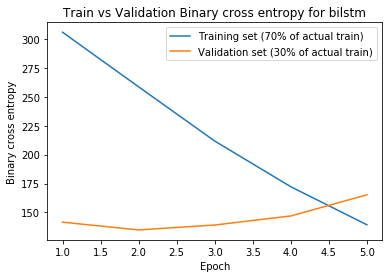

In [14]:
plot(train_loss, val_loss, 'bilstm', 'Binary cross entropy')